In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import h5py
import scipy.signal as ss
import scipy.stats as st
import LFPy
import neuron
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.gridspec import GridSpec
import example_network_parameters as params
from plotting import draw_lineplot, remove_axis_junk, annotate_subplot, colorbar
import plotting
from lfpykernels import KernelApprox
from copy import deepcopy
from parameters import ParameterSet

In [3]:
plt.rcParams.update(plotting.rcParams)
golden_ratio = plotting.golden_ratio
figwidth = plotting.figwidth

In [4]:
neuron.load_mechanisms('mod')

True

In [5]:
# Dataset
md5 = 'adb947bfb931a5a8d09ad078a6d256b0'
OUTPUTPATH_REAL = os.path.join('output', md5)

In [6]:
class Kernel(KernelApprox):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_per_seg_indegree(self, X):
        """Get the in- and out-degree counts per compartment for presynaptic
        population X.

        Parameters
        ----------
        X: str
            presynaptic population

        Returns
        -------
        cell.z.mean(axis=-1): ndarray
            midpoint coordinates along z-axis
        outdegree: ndarray
            expected number of synapses per compartment
        """
        # assess index of presynaptic population in X
        (X_i, ) = np.where(np.array(self.X) == X)[0]

        # estimate number of connections as in Potjans&Diesmann2014
        # K_YX = np.log(1. - C_YX) / np.log(1. - 1. / (N_X * N_Y))
        # accurate for small K/(N_X N_Y):
        K_YX = self.C_YX * self.N_X * self.N_Y

        # account for one-sided truncated distribution of synapses per
        # connection with expectation 'loc' and standard deviation 'scale'
        for i in range(len(self.X)):
            multapsedist = self._get_multapsedist(i)

            # total number of connections
            K_YX[i] = K_YX[i] * multapsedist.mean()

        # per neuron indegree
        k_YX_in = K_YX / self.N_Y

        # class NetworkCell parameters:
        cellParameters = deepcopy(self.cellParameters)
        cellParameters.update(dict(
            # dt=dt,
            # tstop=t_X + tau,
            delete_sections=True
        )
        )

        # Create Cell object representative of whole population
        cell = LFPy.TemplateCell(**cellParameters)

        # need lists of segment references for each cell in order to shift
        # g_pas per segment
        cell.allseglist = neuron.h.List()
        for sec in cell.allseclist:
            for seg in sec:
                cell.allseglist.append(seg)

        # compute probabilities of connections per compartment which will
        # be used to distribute synaptic input currents.
        # Acount for distribution of cells along z-axis:
        # Somatic placement is Gaussian w. z_mean +/- z_std
        # Synapse placement is Gaussian w. u_mean +/- u_std
        # The convolution of two Gaussians is a Gaussian with
        # mean (z_mean + u_mean) and st.dev sqrt(z_std^2 + u_std^2)
        syn_pos = deepcopy(self.synapsePositionArguments[X_i])
        for h, funarg in enumerate(syn_pos['funargs']):
            syn_pos['funargs'][h]['loc'] = \
                funarg['loc'] + self.populationParameters['loc']
            syn_pos['funargs'][h]['scale'] = \
                np.sqrt(funarg['scale']**2 +
                        self.populationParameters['scale']**2)

        # per-compartment connection probability
        p = self.get_rand_idx_area_and_distribution_prob(
            cell,
            **syn_pos)

        # synapses per compartment for each connection.
        # Distinguish between input densities and outdegrees as
        # indegrees affects g_pas while outdegrees scale synaptic weights.
        rho_YX_in = p * k_YX_in[X_i]

        return cell.z.mean(axis=-1), rho_YX_in

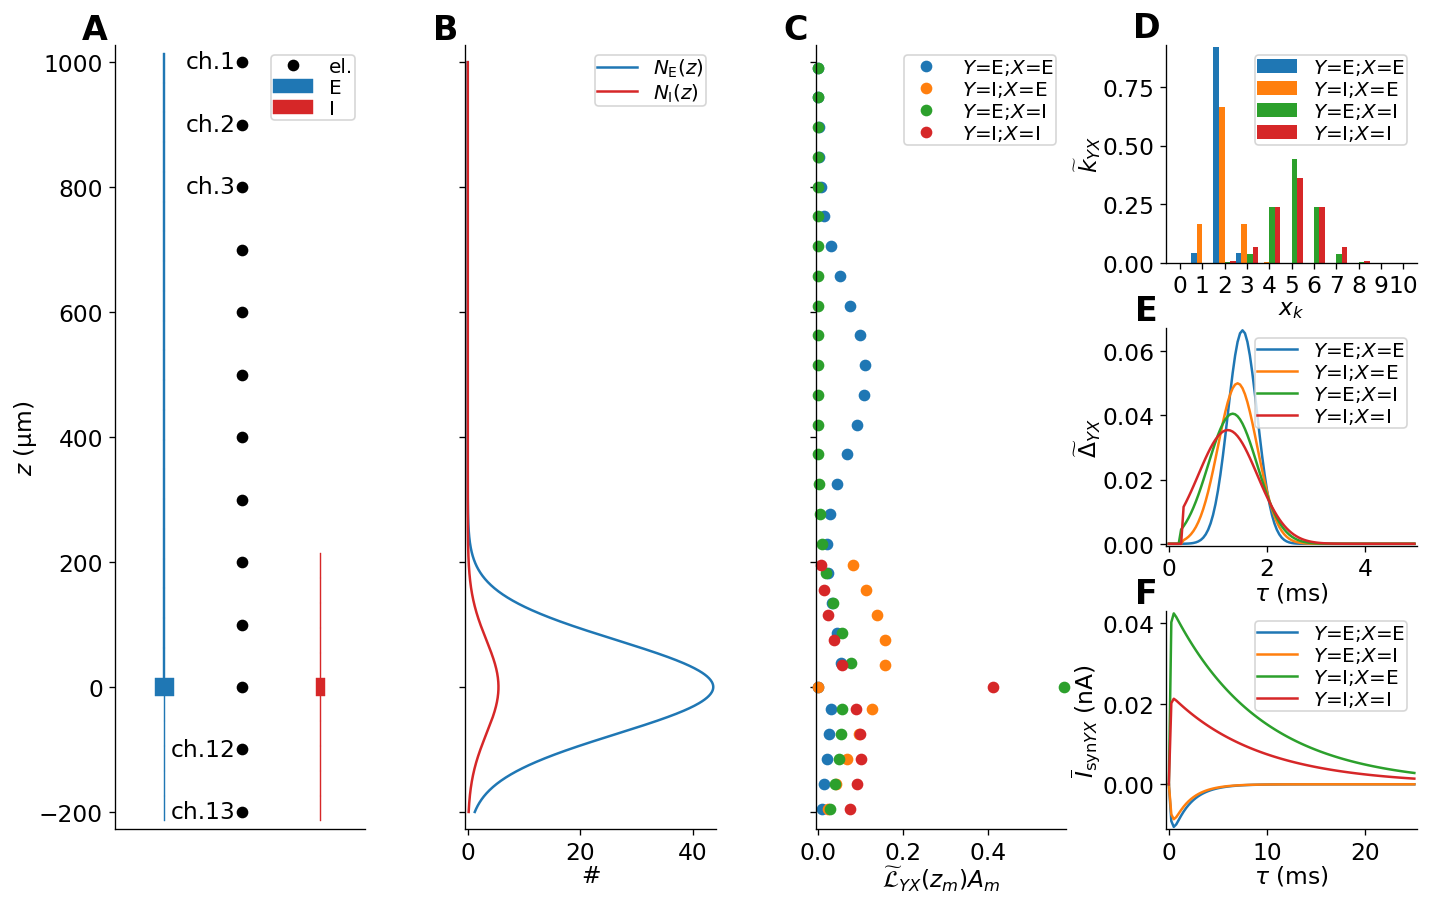

In [9]:
fig = plt.figure(figsize=(figwidth, figwidth / golden_ratio))
fig.subplots_adjust(wspace=0.4, hspace=0.3)
gs = GridSpec(3, 4)


m = ['BallAndSticks_E.hoc', 'BallAndSticks_I.hoc']
X = ['E', 'I']
N_X = params.population_sizes

# E and I colors
colors = ['tab:blue', 'tab:red']

### Cell models
ax0 = fig.add_subplot(gs[:, 0])
remove_axis_junk(ax0)
somapos = [-125, 125]  
for i, (x_, m_, X_) in enumerate(zip(somapos, m, X)):
    zips = []
    cellParameters = dict(
        morphology=m_,
        templatefile='BallAndSticksTemplate.hoc',
        templatename='BallAndSticksTemplate',
        templateargs=None,
        delete_sections=True,
    )
    cell = LFPy.TemplateCell(**cellParameters)
    cell.set_pos(x_, 0, 0)

    # show morphology
    for x, z in cell.get_idx_polygons(projection=('x', 'z')):
        zips.append(list(zip(x, z)))

    polycol = PolyCollection(zips,
                             edgecolors=colors[i],
                             facecolors=colors[i],
                             linewidths=0.25,
                             label=X_)
    ax0.add_collection(polycol)

# laminar probe
x_e = params.electrodeParameters['x']
z_e = params.electrodeParameters['z']
ax0.plot(x_e, z_e, 'ko', label='el.')    

# annotate
for i, (x_i, z_i) in enumerate(zip(x_e, z_e)):
    if (i < 3) or (i > 10):
        ax0.text(x_i-10, z_i, f'ch.{i+1}', va='center', ha='right')


ax0.axis('equal')
ax0.set_xticks([])
ax0.set_ylabel('$z$ (µm)')
ax0.legend()
annotate_subplot(ax0, ncols=4, nrows=1, letter='A', linear_offset=0.02)


# cell-body distribution along z-axis
ax1 = fig.add_subplot(gs[:, 1], sharey=ax0)
remove_axis_junk(ax1)

z = np.arange(-200, 1001)

dist = st.norm.pdf(z, 
                   loc=params.populationParameters['pop_args']['loc'], 
                   scale=params.populationParameters['pop_args']['scale'])
for i, (N, Y) in enumerate(zip(N_X, X)):
    ax1.plot(dist * N, z, color=colors[i], label=r'$N_\mathrm{{' + Y + '}}(z)$')
ax1.legend()
ax1.set_xlabel('#')
plt.setp(ax1.get_yticklabels(), visible=False)
annotate_subplot(ax1, ncols=4, nrows=1, letter='B', linear_offset=0.02)


# synapse distributions (normalized)
ax2 = fig.add_subplot(gs[:, 2], sharey=ax0)
remove_axis_junk(ax2)
for i, (X, N_X) in enumerate(zip(params.population_names,
                                 params.population_sizes)):
    for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                 params.population_sizes,
                                                 params.morphologies)):
        cellParameters = deepcopy(params.cellParameters)
        cellParameters.update(dict(
            morphology=morphology,
            # custom_fun=[set_biophys],
            # custom_fun_args=[dict(Vrest=Vrest)],
        ))

        # some inputs must be lists
        synapseParameters = [
            dict(weight=0, #weights[ii][j],
                 syntype='Exp2Syn',
                 **params.synapseParameters[ii][j])
            for ii in range(len(params.population_names))]
        synapsePositionArguments = [
            params.synapsePositionArguments[ii][j]
            for ii in range(len(params.population_names))]

        # Create kernel approximator object
        kernel = Kernel(
            X=params.population_names,
            Y=Y,
            N_X=np.array(params.population_sizes),
            N_Y=N_Y,
            C_YX=np.array(params.connectionProbability[i]),
            cellParameters=cellParameters,
            populationParameters=params.populationParameters['pop_args'],
            multapseFunction=params.multapseFunction,
            multapseParameters=[params.multapseArguments[ii][j] for ii in range(len(params.population_names))],
            delayFunction=params.delayFunction,
            delayParameters=[params.delayArguments[ii][j] for ii in range(len(params.population_names))],
            synapseParameters=synapseParameters,
            synapsePositionArguments=synapsePositionArguments,
            extSynapseParameters=params.extSynapseParameters,
            nu_ext=1000. / params.netstim_interval,
            n_ext=0, # n_ext[j],
            nu_X=0, #mean_nu_X,
        )

        cell_z, rho_YX = kernel.get_per_seg_indegree(X)
        
        ax2.plot(rho_YX / rho_YX.sum(), cell_z, 'o', clip_on=False, label='$Y$={};$X$={}'.format(Y, X))
ax2.legend()
ax2.set_xlabel(r'$\widetilde{\mathcal{L}}_{YX}(z_m)A_m$')
plt.setp(ax2.get_yticklabels(), visible=False)
annotate_subplot(ax2, ncols=4, nrows=1, letter='C', linear_offset=0.02)


"""
# connection probabilities
ax5 = fig.add_subplot(gs[0, 3])
im = ax5.pcolormesh(np.array(params.connectionProbability), edgecolors='k')
ax5.set_xticks(np.arange(len(params.population_names)) + 0.5)
ax5.set_xticklabels(params.population_names)
ax5.set_yticks(np.arange(len(params.population_names)) + 0.5)
ax5.set_yticklabels(params.population_names)
ax5.set_xlabel('$Y$')
ax5.set_ylabel('$X$')
cb = colorbar(fig, ax5, im, width=0.05, height=1, voffset=0.)
cb.set_label('$C_{YX}$')
annotate_subplot(ax5, ncols=4, nrows=4, letter='D', linear_offset=0.02)
"""

# discretized indegree distributions
ax6 = fig.add_subplot(gs[0, 3])
remove_axis_junk(ax6)
annotate_subplot(ax6, ncols=4, nrows=4, letter='D', linear_offset=0.02)

# workaround the fact that LFPy.Network don't use discrete dist 
# (scipy.stats.rv_discrete class type)
barwidth = 0.25
h = 0  # counter
if params.multapseFunction is np.random.normal:
    for i, (X) in enumerate(params.population_names):
        for j, (Y) in enumerate(params.population_names):
            # capped discrete "normal" distribution
            xk = np.arange(1, 10)
            pk = st.norm.pdf(xk, **params.multapseArguments[i][j])
            pk /= pk.sum()  # probability dist must sum to 1. 
            multapsedist = st.rv_discrete(values=(xk, pk))

            xk = np.arange(11)
            ax6.bar(xk + (-1.5 + h) * barwidth, multapsedist.pmf(xk), width=barwidth, label='$Y$={};$X$={}'.format(Y, X))
            h += 1
elif params.multapseFunction is st.truncnorm:
    for i, (X) in enumerate(params.population_names):
        for j, (Y) in enumerate(params.population_names):
            d = params.multapseFunction(**params.multapseArguments[i][j])
            # number of multapses must be on interval [1, 100]
            # (cap at 100 as more sounds completely unreasonable)
            xk = np.arange(1, 10)
            pk = d.pdf(xk)
            pk /= pk.sum()
            multapsedist = st.rv_discrete(values=(xk, pk))

            xk = np.arange(11)
            ax6.bar(xk + (-1.5 + h) * barwidth, multapsedist.pmf(xk), width=barwidth, label='$Y$={};$X$={}'.format(Y, X))
            h += 1
else:
    raise NotImplementedError

ax6.set_xticks(xk)
ax6.legend()
ax6.set_xlabel(r'$x_k$')
ax6.set_ylabel(r'$\widetilde{k}_{YX}$')



# delay distributions
ax3 = fig.add_subplot(gs[1, 3])
remove_axis_junk(ax3)
tau = np.linspace(0, 5, 101)
for i, (X, N_X) in enumerate(zip(params.population_names,
                                 params.population_sizes)):
    for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                 params.population_sizes,
                                                 params.morphologies)):
        h = params.delayFunction.pdf(tau, **params.delayArguments[i][j])
        h /= h.sum()
        ax3.plot(tau, h, label='$Y$={};$X$={}'.format(Y, X))
ax3.legend()
ax3.set_xlabel('$\\tau$ (ms)')
ax3.set_ylabel(r'$\widetilde{\Delta}_{YX}$')
annotate_subplot(ax3, ncols=4, nrows=4, letter='E', linear_offset=0.02)


# synapse temporal kernels
ax4 = fig.add_subplot(gs[2, 3])
remove_axis_junk(ax4)

def exp2(t, tau1, tau2):
    t_p = (tau2 * tau1) / (tau2 - tau1) * np.log(tau2 / tau1)
    return (np.exp(-t / tau2) - np.exp(-t / tau1)) / (np.exp(-t_p / tau2) - np.exp(-t_p / tau1))


# max synaptic conductance
pset = ParameterSet(os.path.join('parameters', '{}.txt'.format(md5)))
weights = [[pset['weight_EE'], pset['weight_IE']], [pset['weight_EI'], pset['weight_II']]]


# median soma potentials
Vrest_Y = []
for j, name in enumerate(params.population_names):
    with h5py.File(os.path.join(OUTPUTPATH_REAL, 'somav.h5'
                                ), 'r') as f:
        Vrest_Y += [np.median(f[name][()][:, 1000:])]


t = np.linspace(0, 25, 101)
for i, (X, N_X) in enumerate(zip(params.population_names,
                                 params.population_sizes)):
    for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                 params.population_sizes,
                                                 params.morphologies)):
            synpar = dict(
                weight=weights[i][j],
                **params.synapseParameters[i][j])

            ax4.plot(t, 
                     exp2(t, synpar['tau1'], synpar['tau2'])
                     * (Vrest_Y[j] - synpar['e']) * synpar['weight'],
                     label='$Y$={};$X$={}'.format(X, Y))
ax4.legend()
ax4.set_xlabel('$\\tau$ (ms)')
ax4.set_ylabel(r'$\overline{I}_{\mathrm{syn}YX}$ (nA)')
annotate_subplot(ax4, ncols=4, nrows=4, letter='F', linear_offset=0.02)


fig.savefig(os.path.join('figures', 'Figure06.pdf'), bbox_inches='tight', pad_inches=0)